In [146]:
import yfinance as yf
import pandas as pd

dataF = yf.download("EURUSD=X", start="2012-10-7", end="2022-12-5", interval='1d')  # Daily interval
#dataF.Open.iloc

[*********************100%***********************]  1 of 1 completed


In [147]:
import pandas as pd

def calculate_pivots(df, length):
    """Calculate pivot highs and lows."""
    pivots = {'highs': [], 'lows': []}
    for i in range(length, len(df) - length):
        high = df['High'][i]
        low = df['Low'][i]
        
        is_pivot_high = all(high > df['High'][j] for j in range(i - length, i + length + 1) if j != i)
        is_pivot_low = all(low < df['Low'][j] for j in range(i - length, i + length + 1) if j != i)
        
        if is_pivot_high:
            pivots['highs'].append((i, high))
        if is_pivot_low:
            pivots['lows'].append((i, low))
    return pivots

def signal_generator(df, length=5):
    """
    Generate trading signals based on liquidity sweeps logic.
    :param df: DataFrame with Open, High, Low, Close columns.
    :param length: Number of bars to consider for pivot calculation.
    :return: Signal: 1 (short), 2 (long), 0 (no signal).
    """
    pivots = calculate_pivots(df, length)
    close = df['Close'].iloc[-1]

    # Check for liquidity sweeps
    for pivot in pivots['highs']:
        _, pivot_high = pivot
        if close > pivot_high:
            return 2  # Bullish breakout (long)

    for pivot in pivots['lows']:
        _, pivot_low = pivot
        if close < pivot_low:
            return 1  # Bearish breakout (short)

    return 0  # No clear signal


# signal = []
# signal.append(0)
# for i in range(1,len(dataF)):
#     df = dataF[i-1:i+1]
#     signal.append(signal_generator(df))
# signal_generator(data)
# dataF["signal"] = signal

In [148]:
def signal_generator(df):
    """
    Generate trading signals based on liquidity sweeps logic:
    - Bullish sweep: Price sweeps below previous low but closes above
    - Bearish sweep: Price sweeps above previous high but closes below
    
    Returns:
    1 for bearish signal
    2 for bullish signal
    0 for no signal
    """
    current_high = df.High.iloc[-1]
    current_low = df.Low.iloc[-1]
    current_close = df.Close.iloc[-1]
    
    prev_high = df.High.iloc[-2]
    prev_low = df.Low.iloc[-2]
    prev_close = df.Close.iloc[-2]
    
    # Look for bearish sweep (similar to LUXALGO's high sweep)
    if (current_high > prev_high and  # Price sweeps above previous high
        current_close < prev_high and  # But closes below it
        current_close < prev_close):   # Showing bearish pressure
        return 1
    
    # Look for bullish sweep (similar to LUXALGO's low sweep)
    elif (current_low < prev_low and   # Price sweeps below previous low
          current_close > prev_low and  # But closes above it
          current_close > prev_close):  # Showing bullish pressure
        return 2
    
    # No clear sweep pattern
    return 0


In [149]:
data_new = yf.download("EURUSD=X", start="2014-10-7", end="2014-11-7")  # 1-day interval
# Apply the signal generator to your dataframe
signal = []
signal.append(0)  # First candle has no signal since we need previous data
for i in range(1, len(data_new)):
    df = data_new[i-1:i+1]
    signal.append(signal_generator(df))
data_new["signal"] = signal

data_new.signal.value_counts()
# dataF.iloc[:, :]

[*********************100%***********************]  1 of 1 completed


0    19
1     2
2     2
Name: signal, dtype: int64


Signals Taken:
Bearish Signals (1): 2 out of 299
Bullish Signals (2): 2 out of 347
Total Signals Taken: 4 out of 646

Detailed Performance Summary:
Starting Capital: $100,000
Final Capital: $99,787.15
Total Profit/Loss: $-212.85
Number of Trades: 4
Win Rate: 50.00%
Max Drawdown: 0.37%
Average Trade Duration: 10.0 days
Profit Factor: 0.45

Trade Outcome Distribution:
end_of_period    4
Name: exit_type, dtype: int64

Sample of First Few Trades:
  entry_date  exit_date   type  profit_loss      exit_type
0 2014-10-15 2014-11-06  SHORT   158.997774  end_of_period
1 2014-10-21 2014-11-06   LONG  -315.219164  end_of_period
2 2014-11-04 2014-11-06  SHORT    15.907288  end_of_period
3 2014-11-05 2014-11-06   LONG   -72.532892  end_of_period


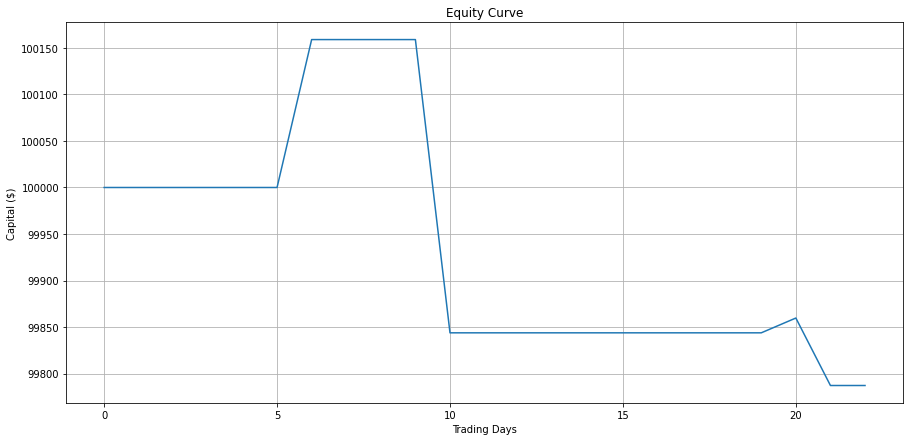

In [150]:
def run_trading_simulation(df, initial_capital=100000):
    """
    Run trading simulation taking EVERY signal with fixed parameters:
    - Trade size: $10,000 per trade
    - Risk per trade: 20% ($2,000)
    - Reward target: 40% ($4,000)
    """
    capital = initial_capital
    trades = []
    capital_history = [initial_capital]  # Track capital over time
    
    # For verification
    signals_taken = {1: 0, 2: 0}  # Count signals taken
    
    for i in range(1, len(df)):
        current_row = df.iloc[i]
        
        # Take every non-zero signal as long as we have capital
        if current_row['signal'] in [1, 2] and capital >= 10000:
            # Record signal count
            signals_taken[current_row['signal']] += 1
            
            if current_row['signal'] == 2:  # Bullish signal
                trade = {
                    'type': 'LONG',
                    'entry': current_row['Close'],
                    'entry_date': current_row.name,
                    'signal': 'BULL'
                }
            else:  # Bearish signal
                trade = {
                    'type': 'SHORT',
                    'entry': current_row['Close'],
                    'entry_date': current_row.name,
                    'signal': 'BEAR'
                }
            
            # Find the exit point by scanning future prices
            for j in range(i + 1, len(df)):
                future_row = df.iloc[j]
                
                if trade['type'] == 'LONG':
                    # Check take profit (40% = 0.4)
                    if future_row['High'] >= trade['entry'] + 0.4:
                        trades.append({
                            **trade,
                            'exit_price': trade['entry'] + 0.4,
                            'profit_loss': 4000,
                            'exit_date': future_row.name,
                            'exit_type': 'take_profit'
                        })
                        capital += 4000
                        break
                    # Check stop loss (20% = 0.2)
                    elif future_row['Low'] <= trade['entry'] - 0.2:
                        trades.append({
                            **trade,
                            'exit_price': trade['entry'] - 0.2,
                            'profit_loss': -2000,
                            'exit_date': future_row.name,
                            'exit_type': 'stop_loss'
                        })
                        capital -= 2000
                        break
                    
                else:  # SHORT trade
                    # Check take profit
                    if future_row['Low'] <= trade['entry'] - 0.4:
                        trades.append({
                            **trade,
                            'exit_price': trade['entry'] - 0.4,
                            'profit_loss': 4000,
                            'exit_date': future_row.name,
                            'exit_type': 'take_profit'
                        })
                        capital += 4000
                        break
                    # Check stop loss
                    elif future_row['High'] >= trade['entry'] + 0.2:
                        trades.append({
                            **trade,
                            'exit_price': trade['entry'] + 0.2,
                            'profit_loss': -2000,
                            'exit_date': future_row.name,
                            'exit_type': 'stop_loss'
                        })
                        capital -= 2000
                        break
                
                # If we reach the end of data, close at last price
                if j == len(df) - 1:
                    profit_loss = 0
                    if trade['type'] == 'LONG':
                        profit_loss = (future_row['Close'] - trade['entry']) * 10000
                    else:
                        profit_loss = (trade['entry'] - future_row['Close']) * 10000
                    
                    trades.append({
                        **trade,
                        'exit_price': future_row['Close'],
                        'profit_loss': profit_loss,
                        'exit_date': future_row.name,
                        'exit_type': 'end_of_period'
                    })
                    capital += profit_loss
        
        capital_history.append(capital)
    
    trades_df = pd.DataFrame(trades)
    
    # Print signal verification
    print("\nSignals Taken:")
    print(f"Bearish Signals (1): {signals_taken[1]} out of 299")
    print(f"Bullish Signals (2): {signals_taken[2]} out of 347")
    print(f"Total Signals Taken: {sum(signals_taken.values())} out of 646")
    
    # Calculate metrics
    if len(trades_df) > 0:
        win_rate = len(trades_df[trades_df['profit_loss'] > 0]) / len(trades_df) * 100
        total_profit = trades_df['profit_loss'].sum()
        
        # Calculate max drawdown from capital history
        peaks = pd.Series(capital_history).expanding(min_periods=1).max()
        drawdowns = (peaks - capital_history) / peaks * 100
        max_drawdown = drawdowns.max()
        
        avg_trade_duration = (trades_df['exit_date'] - trades_df['entry_date']).mean().days
        profit_factor = abs(trades_df[trades_df['profit_loss'] > 0]['profit_loss'].sum()) / abs(trades_df[trades_df['profit_loss'] < 0]['profit_loss'].sum()) if len(trades_df[trades_df['profit_loss'] < 0]) > 0 else float('inf')
    else:
        win_rate = avg_trade_duration = profit_factor = max_drawdown = 0
        total_profit = 0
    
    return {
        'final_capital': capital,
        'total_profit': total_profit,
        'num_trades': len(trades_df),
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'avg_trade_duration': avg_trade_duration,
        'profit_factor': profit_factor,
        'trades': trades_df,
        'signals_taken': signals_taken,
        'capital_history': capital_history
    }

# Run the simulation
results = run_trading_simulation(data_new)

# Print detailed performance summary
print("\nDetailed Performance Summary:")
print(f"Starting Capital: $100,000")
print(f"Final Capital: ${results['final_capital']:,.2f}")
print(f"Total Profit/Loss: ${results['total_profit']:,.2f}")
print(f"Number of Trades: {results['num_trades']}")
print(f"Win Rate: {results['win_rate']:.2f}%")
print(f"Max Drawdown: {results['max_drawdown']:.2f}%")
print(f"Average Trade Duration: {results['avg_trade_duration']:.1f} days")
print(f"Profit Factor: {results['profit_factor']:.2f}")

# Display trade distribution
if len(results['trades']) > 0:
    print("\nTrade Outcome Distribution:")
    print(results['trades']['exit_type'].value_counts())
    
    print("\nSample of First Few Trades:")
    print(results['trades'][['entry_date', 'exit_date', 'type', 'profit_loss', 'exit_type']].head())

# Plot equity curve
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.plot(results['capital_history'])
plt.title('Equity Curve')
plt.xlabel('Trading Days')
plt.ylabel('Capital ($)')
plt.grid(True)
plt.show()

In [151]:
!pip3 install apscheduler
!pip3 install oandapyV20
!pip3 install oanda-candles
!pip3 install config
!pip3 install oanda_candles
from apscheduler.schedulers.blocking import BlockingScheduler
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleClient
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails

In [152]:
from oanda_candles import Pair, Gran, CandleClient
import config

# OANDA API setup
access_token = config.API_TOKEN
accountID = config.ACCOUNT_ID
def get_candles(n):
    client = CandleClient(access_token, real=False)
    collector = client.get_collector(Pair.EUR_USD, Gran.M15)
    candles = collector.grab(n)
    return candles

candles = get_candles(3)
for candle in candles:
    print(float(str(candle.bid.o)) > 1)


True
True
True


In [153]:
def trading_job():
    candles = get_candles(3)
    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    
    for i, candle in enumerate(candles):
        dfstream.loc[i, 'Open'] = float(str(candle.bid.o))
        dfstream.loc[i, 'Close'] = float(str(candle.bid.c))
        dfstream.loc[i, 'High'] = float(str(candle.bid.h))
        dfstream.loc[i, 'Low'] = float(str(candle.bid.l))

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    signal = signal_generator(dfstream.iloc[:-1, :])
    
    # Calculate trade parameters
    trade_value = 10000  # Market value of each trade
    risk_percentage = 0.2  # 20% risk
    reward_percentage = 0.4  # 40% reward
    
    entry_price = float(str(candles[-1].bid.o))  # Open price of the last candle
    risk_amount = trade_value * risk_percentage  # Risk in USD
    pip_value = 10  # Approximate pip value for a $100,000 trade (EUR/USD)
    position_size = trade_value / entry_price  # Units to trade

    # Calculate stop loss and take profit
    stop_loss_pips = risk_amount / pip_value
    take_profit_pips = reward_percentage * trade_value / pip_value
    
    if signal == 1:  # Short trade
        sl_price = entry_price + stop_loss_pips / 10000  # Add stop loss in pips
        tp_price = entry_price - take_profit_pips / 10000  # Subtract take profit in pips
        units = -position_size
    elif signal == 2:  # Long trade
        sl_price = entry_price - stop_loss_pips / 10000  # Subtract stop loss in pips
        tp_price = entry_price + take_profit_pips / 10000  # Add take profit in pips
        units = position_size
    else:
        return  # No trade signal

    # EXECUTING ORDERS
    client = API(access_token)
    mo = MarketOrderRequest(
        instrument="EUR_USD",
        units=int(units),
        takeProfitOnFill=TakeProfitDetails(price=tp_price).data,
        stopLossOnFill=StopLossDetails(price=sl_price).data
    )
    r = orders.OrderCreate(accountID, data=mo.data)
    rv = client.request(r)
    print(rv)


### 2. USING OANDA TO GET DATA FOR BACKTESTING

In [157]:
trading_job()
# scheduler = BlockingScheduler()
# scheduler.add_job(trading_job, 'cron', day_of_week='mon-fri', hour='00-23', minute='1,16,31,46', start_date='2022-01-12 12:00:00', timezone='America/Chicago')
# scheduler.start()

In [160]:
from oandapyV20 import API
import oandapyV20.endpoints.accounts as accounts

client = API(access_token)

def get_account_summary():
    # Request account details
    request = accounts.AccountDetails(accountID)
    response = client.request(request)

    # Extract relevant details
    nav = float(response['account']['NAV'])  # Net Asset Value
    unrealized_pl = float(response['account']['unrealizedPL'])  # Profit/Loss
    margin_used = float(response['account']['marginUsed'])  # Margin Used
    margin_available = float(response['account']['marginAvailable'])  # Margin Available

    # Print account details
    print(f"folio deets:")
    print(f"- Portfolio: ${nav:,.2f}")
    print(f"- P/L: ${unrealized_pl:,.2f}")
    print(f"- Margin Used: ${margin_used:,.2f}")
    print(f"- Margin Available: ${margin_available:,.2f}")

# Call the function to print account details
get_account_summary()


folio deets:
- Portfolio: $99,999.83
- P/L: $0.00
- Margin Used: $0.00
- Margin Available: $99,999.83


In [162]:
def trading_job():
    candles = get_candles(3)
    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    
    # Process candle data
    for i, candle in enumerate(candles):
        dfstream.loc[i, 'Open'] = float(str(candle.bid.o))
        dfstream.loc[i, 'Close'] = float(str(candle.bid.c))
        dfstream.loc[i, 'High'] = float(str(candle.bid.h))
        dfstream.loc[i, 'Low'] = float(str(candle.bid.l))
    
    dfstream = dfstream.astype(float)
    
    entry_price = float(str(candles[-1].bid.o))  # Open price of the last candle
    
    # Fixed parameters
    units = 6969  # Fixed number of units to trade
    stop_loss_pips = 20  # Example: 20 pips stop loss
    take_profit_pips = 40  # Example: 40 pips take profit
    
    # Calculate stop loss and take profit prices
    sl_price = entry_price - stop_loss_pips / 10000  # Subtract stop loss in pips
    tp_price = entry_price + take_profit_pips / 10000  # Add take profit in pips
    
    # Execute order
    client = API(access_token)
    mo = MarketOrderRequest(
        instrument="EUR_USD",
        units=units,  # Fixed units, no need for int() conversion since it's already an integer
        takeProfitOnFill=TakeProfitDetails(price=tp_price).data,
        stopLossOnFill=StopLossDetails(price=sl_price).data
    )
    r = orders.OrderCreate(accountID, data=mo.data)
    rv = client.request(r)
    print(rv)

# Execute single trade
trading_job()

# Uncomment below to run on schedule
# scheduler = BlockingScheduler()
# scheduler.add_job(trading_job, 'cron', day_of_week='mon-fri', hour='00-23', minute='1,16,31,46', start_date='2022-01-12 12:00:00', timezone='America/Chicago')
# scheduler.start()

{'orderCreateTransaction': {'id': '18', 'accountID': '101-001-28121144-002', 'userID': 28121144, 'batchID': '18', 'requestID': '97350162142292833', 'time': '2024-12-26T22:07:33.070461879Z', 'type': 'MARKET_ORDER', 'instrument': 'EUR_USD', 'units': '6969', 'timeInForce': 'FOK', 'positionFill': 'DEFAULT', 'takeProfitOnFill': {'price': '1.04565', 'timeInForce': 'GTC'}, 'stopLossOnFill': {'price': '1.03965', 'timeInForce': 'GTC', 'triggerMode': 'TOP_OF_BOOK'}, 'reason': 'CLIENT_ORDER'}, 'orderFillTransaction': {'id': '19', 'accountID': '101-001-28121144-002', 'userID': 28121144, 'batchID': '18', 'requestID': '97350162142292833', 'time': '2024-12-26T22:07:33.070461879Z', 'type': 'ORDER_FILL', 'orderID': '18', 'instrument': 'EUR_USD', 'units': '6969', 'requestedUnits': '6969', 'price': '1.04259', 'pl': '0.0000', 'quotePL': '0', 'financing': '0.0000', 'baseFinancing': '0', 'commission': '0.0000', 'accountBalance': '99999.8300', 'gainQuoteHomeConversionFactor': '1', 'lossQuoteHomeConversionFac